# Regression

## Description
This Python script is to do linear or logistic regression, using gradient descent or normal equation.

In [1]:
#imports
# Scientific Calculation Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io

# Built-in Module Imports
import math
import time
import enum
import abc

%matplotlib inline

In [2]:
# Regression Type
class RegressionType(enum.Enum):
    linear = 1
    logistic = 2

In [3]:
# Linear Regression Algorithm Class
class RegressionAlgorithm(enum.Enum):
    unspecified = 0
    gradient_descent = 1
    normal_equation = 2

In [4]:
class DataProcessor():
    
    @staticmethod
    def add_x0_column(A):
        return np.insert(A, obj=0, values=1, axis=1)

    @staticmethod
    def augmented_to_coefficient_and_b(A):
        return (A[:, :-1], A[:, -1])

    @staticmethod
    def partition(A, atInd):
        return (A[:atInd], A[atInd:])
    
    @staticmethod
    def get_unique_categories(output, case_sensitive=True):
        if not case_sensitive:
            output = [x.lower() if isinstance(x, str) else x for x in output]
        return np.unique(output)
    
    @staticmethod
    def get_unique_categories_and_binary_outputs(output, case_sensitive=True):
        unique_cat = DataProcessor.get_unique_categories(output, case_sensitive)

        if np.size(unique_cat) <= 2:
            outputs_b = np.zeros(np.size(output))
            mask_0 = (output != unique_cat[0])
            mask_1 = (output == unique_cat[0])
            outputs_b[mask_0] = 0
            outputs_b[mask_1] = 1
        else:
            outputs_b = np.tile(output, (np.size(unique_cat), 1))
            for i, cat in enumerate(unique_cat):
                row = outputs_b[i]
                mask_0 = (output != cat)
                mask_1 = (output == cat)
                row[mask_0] = 0
                row[mask_1] = 1
        
        return (unique_cat, outputs_b)
                

In [5]:
class FeatureNormalizer():
    
    def __init__(self, data, data_has_x0_column=False):
        self.__data = data.astype(np.float64)
        self.__data_has_x0_column = data_has_x0_column 
        self.__scalars = np.ones(np.size(data, axis=1))
        self.__calculate_scalars()
    
    def normalized_feature(self):
        return self.normalize_new_feature(self.__data, self.__data_has_x0_column)
    
    def normalize_new_feature(self, data, input_has_x0_column=False):
        if input_has_x0_column:
            avg = np.insert(self.__avg, obj=0, values=0)
            std = np.insert(self.__std, obj=0, values=1)
        else:
            avg = self.__avg
            std = self.__std
        return (data - avg) / std
        
    def __calculate_scalars(self):
        if self.__data_has_x0_column:
            self.__avg = np.average(self.__data[:, 1:], axis=0)
            self.__std = np.std(self.__data[:, 1:], axis=0)
        else:
            self.__avg = np.average(self.__data, axis=0)
            self.__std = np.std(self.__data, axis=0)

In [6]:
class RegressionTrainer(metaclass=abc.ABCMeta):
    
    def __init__(self, coefficient_matrix, outputs, regularization_lambda=0.0):
        self._x = coefficient_matrix
        self._y = outputs
        self._regularization_lambda = regularization_lambda

    @property
    def weights(self):
        return self._theta

    def start_training(self,
                       training_algorithm=RegressionAlgorithm.unspecified,
                       learning_rate=0.01,
                       time_limit=None,
                       iteration_limit=None,
                       print_cost_while_training=False):
        self.__print_start_training_message_and_log_time()
        
        self._setup_training()
        self.__reset_thetas()
        
        if not training_algorithm or training_algorithm == RegressionAlgorithm.unspecified:
            training_algorithm = self._calculate_optimized_training_alg()
        
        print('Training......')

        self._train(training_algorithm,
                    learning_rate,
                    time_limit,
                    iteration_limit,
                    print_cost_while_training)
        
        self.__print_end_training_message()

    @abc.abstractmethod
    def _setup_training(self):
        print('Setting up trainer......')

    @abc.abstractmethod
    def _calculate_optimized_training_alg(self):
        pass

    @abc.abstractmethod
    def _hypothesis(self):
        pass
    
    @abc.abstractmethod
    def _train(self,
               training_algorithm=RegressionAlgorithm.unspecified,
               learning_rate=0.01,
               time_limit=None,
               iteration_limit=None,
               print_cost_while_training=False):
        pass

    def _cost(self):
        h_theta_x = self._hypothesis()
        diff = self._y - h_theta_x
        diff_squared = np.power(diff, 2)
        diff_squared_sum = np.sum(diff_squared.transpose(), axis=0)
        theta_squared = np.power(self._theta, 2)
        theta_squared = theta_squared.transpose()
        theta_squared[0] = 0
        theta_squared = theta_squared.transpose()
        theta_squared_sum = np.sum(theta_squared.transpose(), axis=0)
        total = diff_squared_sum + self._regularization_lambda * theta_squared_sum
        return total / (2 * self._get_num_samples())
    
    def _derivative_of_cost(self):
        h_theta_x = self._hypothesis().astype(np.float64)
        diff = (h_theta_x - self._y).astype(np.float64)
        diff_scaled_with_x_sum = (self._x.transpose() @ diff.transpose()).transpose()
        regularization_vector = self._theta * self._regularization_lambda / self._get_num_samples()
        regularization_vector = regularization_vector.transpose()
        regularization_vector[0] = np.float64(0)
        regularization_vector = regularization_vector.transpose()
        return diff_scaled_with_x_sum / self._get_num_samples() + regularization_vector
    
    def _train_with_gradient_descent(self,
                                      learning_rate=0.01,
                                      time_limit=None,
                                      iteration_limit=None,
                                      print_cost_while_training=False):
        last_cost = self._cost()
        cost_not_change_count = 0
        cost_check_frequency = 1000
        i = 1
        start_time = time.time()
        condition = True
        # If the cost hasn't changed in 20 (2 * 10) iterations, it converged.
        while condition:
            self._theta -= self._derivative_of_cost() * learning_rate
            # Check and print cost every 10 iterations
            if i == 1 or i % cost_check_frequency == 0:
                current_cost = self._cost()
                if print_cost_while_training:
                    print('Cost of iteration {0}: {1}'.format(i, current_cost))
                cost_equal = False
                try:
                    cost_equal = all(current_cost == last_cost)
                except TypeError as e:
                    cost_equal = current_cost == last_cost
                if cost_equal:
                    cost_not_change_count += 1
                last_cost = current_cost
            i += 1
            condition = cost_not_change_count < 2
            if time_limit is not None:
                condition = condition and (time.time() - start_time) < time_limit
            if iteration_limit is not None:
                condition = condition and i <= iteration_limit

    def _get_num_features(self):
        return np.size(self._x, axis=1)
    
    def _get_num_samples(self):
        return np.size(self._x, axis=0)
    
    def __print_start_training_message_and_log_time(self):
        print('Initializing......')
        self.__training_start_time = time.time()
    
    def __print_end_training_message(self):
        end_time = time.time()
        print('Used {0:.10f} seconds to train model with {1} samples and {2} features.'.format\
             (end_time - self.__training_start_time, self._get_num_samples(), self._get_num_features() - 1))
        print('Training finished.')
    
    def __reset_thetas(self):
        self._theta.fill(0)

In [7]:
class RegressionTrainerLinear(RegressionTrainer):
    
    def __get_feature_count_threshold(self):
        return 10000
    
    # Override (abstract)
    def _setup_training(self):
        super()._setup_training()
        self._theta = np.zeros(np.size(self._x, axis=1))
    
    # Override (abstract)
    def _calculate_optimized_training_alg(self):
        feature_count_small = self._get_num_features() < self.__get_feature_count_threshold()
        if feature_count_small:
            return RegressionAlgorithm.normal_equation
        else:
            return RegressionAlgorithm.gradient_descent
    
    # Override (abstract)
    def _hypothesis(self):
        return self._theta @ self._x.transpose()

    # Override (abstract)
    def _train(self,
               training_algorithm=RegressionAlgorithm.unspecified,
               learning_rate=0.01,
               time_limit=None,
               iteration_limit=None,
               print_cost_while_training=False):
        if training_algorithm == RegressionAlgorithm.gradient_descent:
            self._train_with_gradient_descent(learning_rate, time_limit, iteration_limit, print_cost_while_training)
        elif training_algorithm == RegressionAlgorithm.normal_equation:
            self.__train_with_normal_equation()
        else:
            raise ValueError('Cannot start training, no linear regression algorithm specified.')

    def __train_with_normal_equation(self):
        x = self._x
        x_trans = x.transpose()
        y = self._y
        regularization_matrix = np.identity(self._get_num_features())
        regularization_matrix[0][0] = 0
        regularization_matrix *= self._regularization_lambda
        try:
            result = np.linalg.inv(x_trans @ x + regularization_matrix) @ x_trans @ y
        except ValueError as e:
            raise Exception('Cannot calculate weights with normal equation.') from e
        else:
            self._theta = result

In [8]:
class RegressionTrainerLogistic(RegressionTrainer):
    
    def __init__(self,
                 coefficient_matrix,
                 outputs,
                 regularization_lambda=0.0,
                 output_case_sensitive=True):
        super().__init__(coefficient_matrix, outputs, regularization_lambda)
        self.__output_case_sensitive = output_case_sensitive
    
    @property
    def categories(self):
        return self.__categories

    def __get_num_categories(self):
        return np.size(self.__categories)
    
    # Override
    def _setup_training(self):
        super()._setup_training()
        unique_cat, b_output = DataProcessor.get_unique_categories_and_binary_outputs(self._y, self.__output_case_sensitive)
        self.__categories = unique_cat
        self._y = b_output
        cat_count = self.__get_num_categories()
        if cat_count < 2:
            raise ValueError('Cannot do logistic regression, there is only one kind of output.')
        elif cat_count == 2:
            self.__binary_classification = True
            self._theta = np.zeros(self._get_num_features())
        else:
            self.__binary_classification = False
            theta_shape = (cat_count, self._get_num_features())
            self._theta = np.zeros(shape=theta_shape)
            
    # Override (abstract)
    def _calculate_optimized_training_alg(self):
        return RegressionAlgorithm.gradient_descent
    
    # Override (abstract)
    def _hypothesis(self):
        theta_transpose_x = self._theta @ self._x.transpose()
        result = np.zeros(shape=(self.__get_num_categories(), self._get_num_samples()))
        result.fill(math.e)
        result = result ** (-1 * theta_transpose_x)
        result = 1/ (1 + result)
        return result

    # Override (abstract)
    def _train(self,
               training_algorithm=RegressionAlgorithm.unspecified,
               learning_rate=0.01,
               time_limit=None,
               iteration_limit=None,
               print_cost_while_training=False):
        if training_algorithm == RegressionAlgorithm.gradient_descent:
            self._train_with_gradient_descent(learning_rate, time_limit, iteration_limit, print_cost_while_training)
        else:
            raise ValueError('Cannot start training, no logistic regression algorithm specified.')

In [9]:
class RegressionPredictor(metaclass=abc.ABCMeta):
    def __init__(self, weights, feature_normalizer):
        self._weights = weights
        self._feature_normalizer = feature_normalizer
    
    @abc.abstractmethod
    def predict(self, data):
        pass

In [10]:
class RegressionPredictorLinear(RegressionPredictor):
    # Override (abstract)
    def predict(self, data):
        normalized_feature = self._feature_normalizer.normalize_new_feature(data, False)
        normalized_feature = DataProcessor.add_x0_column(normalized_feature)
        return np.array(self._weights @ normalized_feature.transpose())

In [11]:
class RegressionPredictorLogistic(RegressionPredictor):
    
    # Override
    def __init__(self, weights, feature_normalizer, categories):
        super().__init__(weights, feature_normalizer)
        self.__categories = categories

    # Override (abstract)
    def predict(self, data):
        normalized_feature = self._feature_normalizer.normalize_new_feature(data, False)
        normalized_feature = (DataProcessor.add_x0_column(normalized_feature)).astype(np.float64)
        hypothesis = (self._weights).astype(np.float64) @ normalized_feature.transpose()
        if np.size(self.__categories) <= 2:
            return np.array([self.__categories[0] if p >= 0.5 else self.__categories[1] for p in hypothesis])
        else:
            max_ind = np.argmax(hypothesis, axis=0)
            return np.array([self.__categories[ind] for ind in max_ind])

In [12]:
class RegressionSetup(metaclass=abc.ABCMeta):
    def __init__(self,
                 data,
                 test_sample_ratio=0.05,
                 learning_rate=0.01,
                 regularization_lambda=0.0,
                 regression_algorithm=RegressionAlgorithm.unspecified):
        if data is None:
            raise ValueError('Cannot initialize regression setup, no data.')
        if not 0 <= test_sample_ratio < 1:
            raise ValueError('Cannot initialize regression setup, invaild test sample ratio.')

        self.data = data
        self.test_sample_ratio = test_sample_ratio
        self.learning_rate = learning_rate
        self.regularization_lambda = regularization_lambda
        self.regression_algorithm = regression_algorithm
        
    @abc.abstractproperty
    def regression_type(self):
        pass

In [13]:
class RegressionSetupLinear(RegressionSetup):
        
    # Override (abstract)
    @property
    def regression_type(self):
        return RegressionType.linear

In [14]:
class RegressionSetupLogistic(RegressionSetup):
    def __init__(self,
                 data,
                 test_sample_ratio=0.05,
                 learning_rate=0.01,
                 regularization_lambda=0.0,
                 regression_algorithm=RegressionAlgorithm.unspecified,
                 output_case_sensitive=True):
        super().__init__(data, test_sample_ratio, learning_rate, regularization_lambda, regression_algorithm)
        self.output_case_sensitive = output_case_sensitive

    # Override (abstract)
    @property
    def regression_type(self):
        return RegressionType.logistic

In [15]:
class Regression():
    def __init__(self, setup):
        self.__trained = False
        self.__raw_data = setup.data
        self.__reg_type = setup.regression_type
        self.__test_sample_ratio = setup.test_sample_ratio
        self.__learning_rate = setup.learning_rate
        self.__regularization_lambda = setup.regularization_lambda
        if self.__reg_type == RegressionType.logistic:
            self.__output_case_sensitive = setup.output_case_sensitive
        self.__reg_alg = setup.regression_algorithm
        self.__setup_samples()
        
        if self.__reg_type == RegressionType.linear:
            self.__trainer = RegressionTrainerLinear(coefficient_matrix=self.__x_training,
                                                     outputs=self.__y_training,
                                                     regularization_lambda=self.__regularization_lambda)
            print('Linear trainer setup.')
        elif self.__reg_type == RegressionType.logistic:
            self.__trainer = RegressionTrainerLogistic(coefficient_matrix=self.__x_training,
                                                       outputs=self.__y_training,
                                                       regularization_lambda=self.__regularization_lambda,
                                                       output_case_sensitive=self.__output_case_sensitive)
            print('Logistic trainer setup.')
            
    def train(self,
              time_limit=None,
              iteration_limit=None,
              print_cost=False):
        self.__trained = False
        if not self.__trainer:
            raise AttributeError('Cannot start training, trainer not found.')
        self.__trainer.start_training(training_algorithm=self.__reg_alg,
                                      learning_rate=self.__learning_rate,
                                      time_limit=time_limit,
                                      iteration_limit=iteration_limit,
                                      print_cost_while_training=print_cost)
        self.__trained = True
        self.__setup_predictor()
        self.__print_error_rate()

    def predict(self, data):
        if not self.__predictor:
            raise Exception('Cannot predict, no predictor found.')
        return (self.__predictor.predict(data)).flatten()

    def __setup_samples(self):
        if self.__raw_data is None:
            raise ValueError('Cannot setup samples, no data.')
        num_training_sample = self.__get_training_sample_count()
        self.__x_training = self.__raw_data[:num_training_sample, :-1]
        self.__y_training = self.__raw_data[:num_training_sample, -1]
        self.__x_testing = self.__raw_data[num_training_sample:, :-1]
        self.__y_testing = self.__raw_data[num_training_sample:, -1]
        self.__preprocess_training_set_features()
    
    def __setup_predictor(self):
        if not self.__trained:
            raise Exception('Cannot setup predictor, model has not been trained.')
        if self.__reg_type == RegressionType.linear:
            self.__predictor = RegressionPredictorLinear(weights=self.__trainer.weights,
                                                         feature_normalizer=self.__feature_normalizer)
        elif self.__reg_type == RegressionType.logistic:
            self.__predictor = RegressionPredictorLogistic(weights=self.__trainer.weights,
                                                           feature_normalizer=self.__feature_normalizer,
                                                           categories=self.__trainer.categories)

    def __print_error_rate(self):
        error_rate = self.__get_testing_set_error_rate()
        print('Error rate is {0:.2f}%.'.format(error_rate * 100))

    def __get_training_sample_count(self):
        total_sample_count = np.size(self.__raw_data, axis=0)
        return math.ceil((1.0 - self.__test_sample_ratio) * total_sample_count)
    
    def __preprocess_training_set_features(self):
        if self.__x_training is None:
            raise ValueError('Cannot preprocess training set features, no data.')
        self.__feature_normalizer = FeatureNormalizer(self.__x_training)
        self.__x_training = self.__feature_normalizer.normalized_feature()
        self.__x_training = DataProcessor.add_x0_column(self.__x_training)
    
    def __get_testing_set_error_rate(self):
        if not self.__predictor:
            raise Exception('Cannot get error rate, no predictor found.')
        testing_sample_predictions = self.predict(self.__x_testing)
        return self.__get_error_rate(testing_sample_predictions, self.__y_testing)
            
    def __get_error_rate(self, prediction, actual):
        if self.__reg_type == RegressionType.linear:
            diff = np.abs((prediction - actual)/actual)
            diff = diff[~np.isnan(diff)]
            return np.average(diff)
        elif self.__reg_type == RegressionType.logistic:
            match = prediction == actual
            match_count = np.count_nonzero(match)
            total_count = np.size(actual)
            return (total_count - match_count) / total_count

## Linear Regression Testing

In [16]:
# Get Data
df = pd.read_csv('housing_data/housing.data', header=None, delim_whitespace=True)
data_linear_reg = df.as_matrix()
if data_linear_reg is not None:
    print('Successfully queried data.')

Successfully queried data.


### Normal Equation Testing

In [17]:
# Initialize Setup
setup = RegressionSetupLinear(data=data_linear_reg,
                              test_sample_ratio=0.05,
                              regularization_lambda=150,
                              regression_algorithm=RegressionAlgorithm.normal_equation)

In [18]:
# Initialize Regression
regression = Regression(setup)
regression.train()

Linear trainer setup.
Initializing......
Setting up trainer......
Training......
Used 0.0003540516 seconds to train model with 481 samples and 13 features.
Training finished.
Error rate is 15.32%.


In [19]:
features = np.matrix('0.10574   0.00  27.740  0  0.6090  5.9830  98.80  1.8681   4  711.0  20.10 390.11  18.07')
actual = 13.6
prediction = regression.predict(features)
print('Prediction: {0}.\nActual: {1}.'.format(prediction, actual))

Prediction: [ 16.8008594].
Actual: 13.6.


### Gradient Descent Testing

In [20]:
# Initialize Setup
setup = RegressionSetupLinear(data=data_linear_reg,
                              test_sample_ratio=0.05,
                              learning_rate=0.01,
                              regularization_lambda=150,
                              regression_algorithm=RegressionAlgorithm.gradient_descent)

In [21]:
# Initialize Regression
regression = Regression(setup)
regression.train(time_limit=10)

Linear trainer setup.
Initializing......
Setting up trainer......
Training......
Used 0.1644279957 seconds to train model with 481 samples and 13 features.
Training finished.
Error rate is 15.32%.


In [22]:
features = np.matrix('0.10574   0.00  27.740  0  0.6090  5.9830  98.80  1.8681   4  711.0  20.10 390.11  18.07')
actual = 13.6
prediction = regression.predict(features)
print('Prediction: {0}.\nActual: {1}.'.format(prediction, actual))

Prediction: [ 16.8008594].
Actual: 13.6.


## Logistic Regression Testing

### Iris

In [23]:
# Get Data
df = pd.read_csv('iris_data/iris.data', header=None)
df = df.reindex(np.random.permutation(df.index))
data_logistic_reg = df.as_matrix()
if data_logistic_reg is not None:
    print('Successfully queried data.')

Successfully queried data.


In [24]:
# Initialize Setup
setup = RegressionSetupLogistic(data=data_logistic_reg,
                                test_sample_ratio=0.1,
                                learning_rate=0.1,
                                regularization_lambda=0.2)


In [25]:
# Initialize Regression
regression = Regression(setup)
regression.train(time_limit=60)

Logistic trainer setup.
Initializing......
Setting up trainer......
Training......
Used 10.3965530396 seconds to train model with 135 samples and 4 features.
Training finished.
Error rate is 13.33%.


In [26]:
features = np.matrix('6.4,2.8,5.6,2.1')
actual = 'Iris-virginica'
prediction = regression.predict(features)
print('Prediction: {0}.\nActual: {1}.'.format(prediction, actual))

Prediction: ['Iris-virginica'].
Actual: Iris-virginica.


### Decision Boundry with Two Features

In [27]:
# Get Data
df = pd.read_csv('iris_data/iris.data', header=None)
df = df.reindex(np.random.permutation(df.index))
data_logistic_reg = df.as_matrix()
# Make it a binary classification problem.
data_logistic_reg[:, -1] = np.where(data_logistic_reg[:, -1] == 'Iris-setosa', 1, 0)
# Reduct two only two features.
iris_data_binary = np.delete(data_logistic_reg, np.s_[2:-1], axis=1)
if iris_data_binary is not None:
    print('Successfully queried data.')

Successfully queried data.


In [28]:
class0 = iris_data_binary[np.where(iris_data_binary[:, -1] == 0)]
class1 = iris_data_binary[np.where(iris_data_binary[:, -1] == 1)]

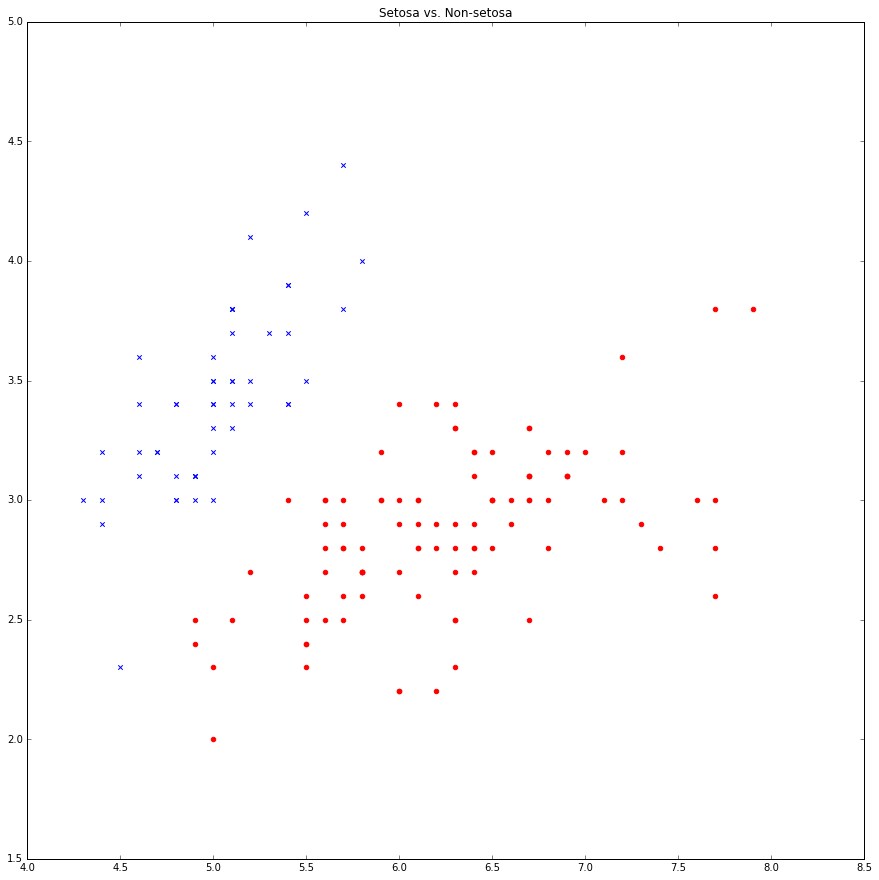

In [29]:
plt.figure(figsize=(15, 15))
plt.scatter(class0[:, 0], class0[:, 1], color='red', marker='o')
plt.scatter(class1[:, 0], class1[:, 1], color='blue', marker='x')
plt.title('Setosa vs. Non-setosa')
plt.show()

In [30]:
# Initialize Setup
setup = RegressionSetupLogistic(data=iris_data_binary,
                                test_sample_ratio=0.1,
                                learning_rate=0.1,
                                regularization_lambda=0.2)

In [31]:
# Initialize Regression
regression = Regression(setup)
regression.train(time_limit=60)

Logistic trainer setup.
Initializing......
Setting up trainer......
Training......


ValueError: non-broadcastable output operand with shape (3,) doesn't match the broadcast shape (2,3)

### Hand Written Digits

In [ ]:
# Get Data
mat_data = scipy.io.loadmat('digits_data/hand_written_digits.mat')
data = np.append(mat_data['X'], mat_data['y'], axis=1)
np.random.shuffle(data)
if data is not None:
    print('Successfully queried data.')

In [ ]:
# Initialize Setup
setup = RegressionSetupLogistic(data=data[0:100],
                                test_sample_ratio=0.1,
                                learning_rate=0.1,
                                regularization_lambda=0.2)

In [ ]:
# Initialize Regression
regression = Regression(setup)
regression.train(time_limit=60)